#### Get search interest data

In [11]:
from pytrends.request import TrendReq
from pytrends import dailydata

pytrends = TrendReq(hl='en-US', timeout=(10, 25), retries=2, backoff_factor=0.1, requests_args={'verify':False})

kw_list = ['Johnny Depp']
# 184 is Celebrities and Entertainment
pytrends.build_payload(kw_list, cat=184, gprop="news")


/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnin

In [15]:
df = pytrends.get_historical_interest(
                    kw_list, 
                    year_start=2010, 
                    month_start=1, 
                    day_start=1, 
                    year_end=2022, 
                    month_end=1, 
                    day_end=1,
                    cat=184,
                    gprop='news',
                    sleep=0
                    )


/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/pytrends/request.py:589: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(week_df)
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/ur

In [17]:
import pandas as pd
df.to_parquet('johnny_depp_hourly_interest_20100101_20190101.parquet')

In [88]:
print(df.head(5))

                     Johnny Depp  isPartial
date                                       
2010-01-01 00:00:00           81      False
2010-01-01 01:00:00            0      False
2010-01-01 02:00:00            0      False
2010-01-01 03:00:00            0      False
2010-01-01 04:00:00          100      False


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

df = pd.read_parquet('johnny_depp_hourly_interest_20100101_20220101.parquet')

In [3]:
import datetime as dt
monthly = df.loc[(df.index <= dt.datetime(2020, 1, 1)) & (df.index > dt.datetime(2015, 1, 1))].resample('M').mean()
weekly = df.loc[(df.index <= dt.datetime(2020, 1, 1)) & (df.index > dt.datetime(2015, 1, 1))].resample('7D').mean()
daily = df.loc[(df.index <= dt.datetime(2020, 1, 1)) & (df.index > dt.datetime(2015, 1, 1))].resample('1D').mean()

Text(0.5, 1.0, 'Google Trends search rate for Johnny Depp')

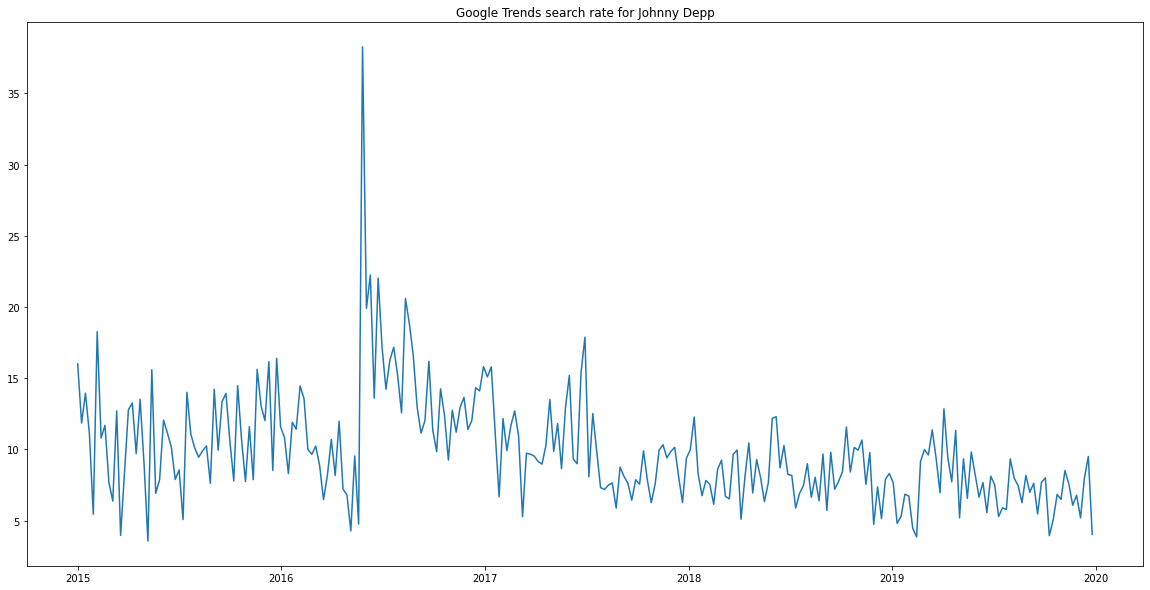

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=weekly.index.values, y=weekly['Johnny Depp'].values, ax=ax)
ax.set_title('Google Trends search rate for Johnny Depp')

There's really a huge variance in the data. In particular, December 2018 doesn't look like there's any huge difference to the main trend. 

Acording to these articles: https://www.vuelio.com/uk/blog/how-long-does-a-news-story-last/ and https://www.niemanlab.org/2019/01/a-typical-big-news-story-in-2018-lasted-about-7-days-until-we-moved-on-to-the-next-crisis/, the average big story these days lasts only 7 days. Therefore, we'll assume that the majority of people who are interested in the topic and could be influenced have been exposed to the story within the first 7 days.

But for now we'll just test whether the amount of media attention is outside the distribution. For this we will take the daily interest rate from 1/1/2017 until 18/12/2018 (the date when the op ed was published by Washington Post) and compare the distribution with data between 18/12/18-25/12/18. 

The null hypothesis here is that the op ed resulted in no statistically significant increase on the number of times the name of Johnny Depp was mentioned. Alternative hypothesis is that there is a statistically significant increase. Givent the size of the dataset we assume the alpha of 0.05.

In [5]:
import datetime as dt
from scipy.stats import ttest_ind

published = dt.datetime(2018, 12, 18)
week_1_end = dt.datetime(2018, 12, 26)
week_2_end = dt.datetime(2019, 1, 2)

base = df.loc[(df.index > dt.datetime(2018, 1, 1)) & (df.index < published), ['Johnny Depp']].values

# just in case test for a period of 1 week, 2 weeks and 3 weeks
test_1w = df.loc[(df.index >= published) & (df.index < week_1_end), ['Johnny Depp']].values
test_2w = df.loc[(df.index >= published) & (df.index < week_2_end), ['Johnny Depp']].values

res_1w = ttest_ind(test_1w, base, alternative='greater')
res_2w = ttest_ind(test_2w, base, alternative='greater')
print(f"{res_1w}\n{res_2w}")

Ttest_indResult(statistic=array([-0.2880926]), pvalue=array([0.61335863]))
Ttest_indResult(statistic=array([-0.17838666]), pvalue=array([0.57078829]))


Based on the p-value of 0.93 we cannot reject the null hypothesis. It appears that there is no statistically significant correlation between the date when the op ed had been published and the number of times the name of Johnny Depp was a searched on Google and related services.

We will also try and create an ARIMA model for the time series and then generate predictions for the 14 days starting 18/12/2018 and compare predictions with the actual data and see if there's a statistically significant difference there.

In [6]:
from pmdarima.arima import auto_arima

data = daily.loc[(daily.index > dt.datetime(2018, 1, 1)) & (daily.index <= dt.datetime(2018, 12, 18)), "Johnny Depp"]
y = data.values
X = data.index.values.reshape(-1, 1)

In [7]:
mr = auto_arima(y, error_action='ignore', seasonal=True, m=100)   # works: m=9, 10, 16, 38, 55, 100
res_r = mr.predict(n_periods=7)

Text(0.5, 1.0, 'Google Trends search rate for Johnny Depp')

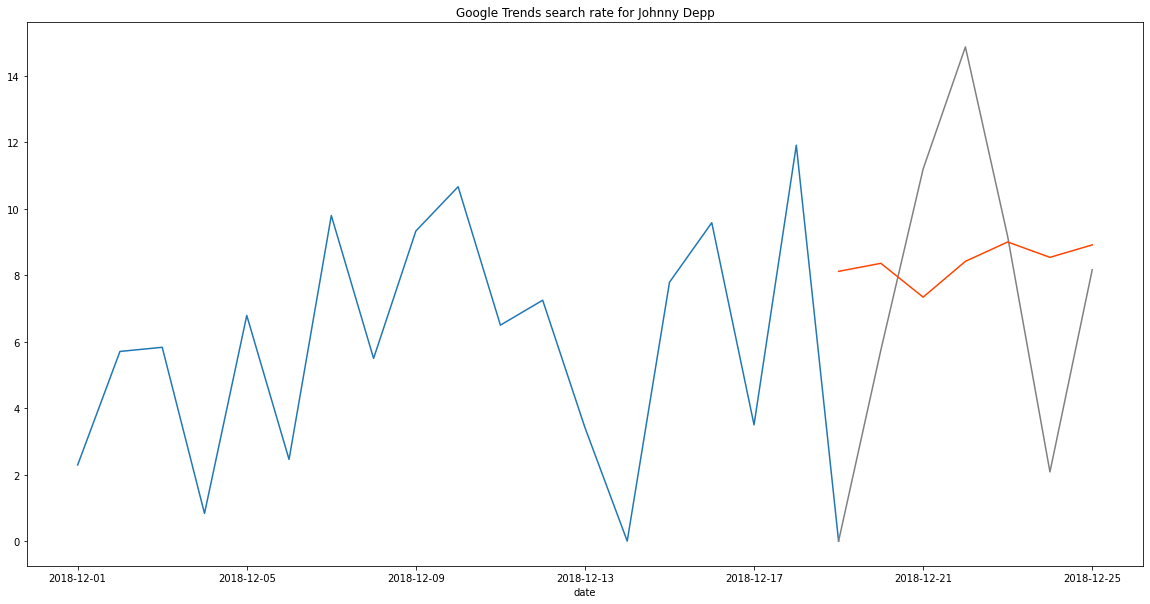

In [9]:
plot_d = daily.loc[(daily.index <= dt.datetime(2018, 12, 19)) & (daily.index >= dt.datetime(2018, 12, 1)), :]
plot_k = daily.loc[(daily.index > dt.datetime(2018, 12, 18)) & (daily.index <= dt.datetime(2018, 12, 25)), :]
x_res = daily.loc[(daily.index >= dt.datetime(2018, 12, 19)) & (daily.index <= dt.datetime(2018, 12, 25)), :].index

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=plot_d.index.values, y=plot_d['Johnny Depp'].values, ax=ax)
sns.lineplot(x=plot_k.index.values, y=plot_k['Johnny Depp'].values, ax=ax, color='gray')
sns.lineplot(x=x_res, y=res_r, color='orangered')
ax.set_title('Google Trends search rate for Johnny Depp')


/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date'>

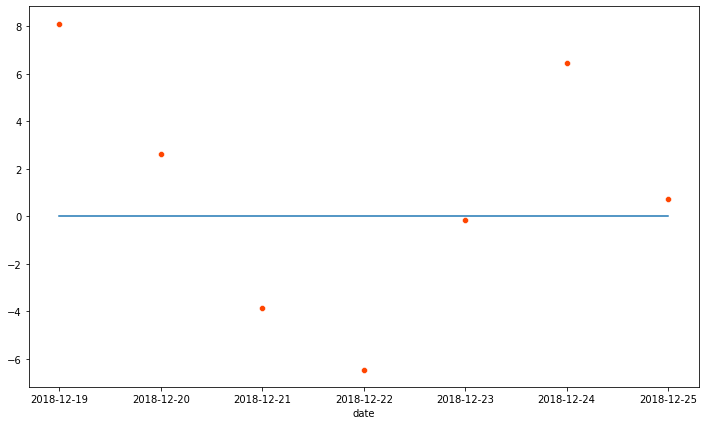

In [14]:
import numpy as np

# residuals plot
fig = plt.figure(figsize=(12, 7))

x = x_res
y = res_r - plot_k['Johnny Depp'].values
zeros = np.zeros(res_r.shape[0])
sns.scatterplot(x, y, color='orangered')
sns.lineplot(x, zeros)

This is a rather confusing result. You would expect that after such a high-profile publication people would search for Johnny Depp more often than they did before. Instead, what we see is that the interest is acually lower than it was before.

There are a couple possible explanations that I could think of:

- The number of searches for Johnny Depp have gone down as many users would instead search for "Amber Heard", i.e. the interest in Ms. Heard should increase.
- The number of searches for Johnny Depp have decreased overall but the searches that remain carry a more negative sentiment than in the periods prior.

In [81]:
# get trends data for Amber Heard for the same period as Johnny Depp
kw_heard = ['Amber Heard']

heard_interest = pytrends.get_historical_interest(
                    kw_heard, 
                    year_start=2010, 
                    month_start=1, 
                    day_start=1, 
                    year_end=2022, 
                    month_end=1, 
                    day_end=1,
                    cat=184,
                    gprop='news',
                    sleep=0
                    )

/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/pytrends/request.py:589: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(week_df)
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/ur

In [50]:
df_h = pd.read_parquet('amber_heard_hourly_interest_20100101_20220101.parquet')

<AxesSubplot:>

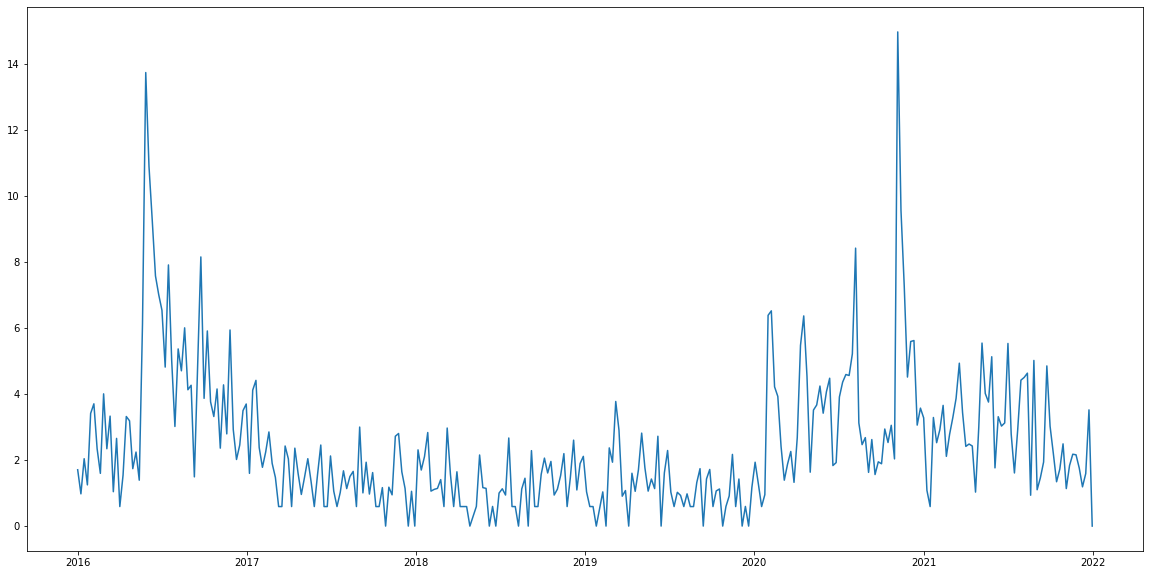

In [53]:
weekly_h = df_h.loc[(df_h.index <= dt.datetime(2022, 4, 1)) & (df_h.index > dt.datetime(2016, 1, 1))].resample('7D').mean()
daily_h = df_h.loc[(df_h.index <= dt.datetime(2022, 4, 1)) & (df_h.index > dt.datetime(2016, 1, 1))].resample('1D').mean()

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=weekly_h.index.values, y=weekly_h['Amber Heard'].values, ax=ax)

In [62]:
base_h = df_h.loc[(df_h.index < published) & (df_h.index > dt.datetime(2018, 1, 1)), ['Amber Heard']].values

test_1w_h = df_h.loc[(df_h.index >= published) & (df_h.index < week_1_end), ['Amber Heard']].values
test_2w_h = df_h.loc[(df_h.index >= published) & (df_h.index < week_2_end), ['Amber Heard']].values

res_1w_h = ttest_ind(test_1w_h, base_h, alternative='greater')
res_2w_h = ttest_ind(test_2w_h, base_h, alternative='greater')

print(f"{res_1w_h}\n{res_2w_h}")

Ttest_indResult(statistic=array([-0.11259693]), pvalue=array([0.54482345]))
Ttest_indResult(statistic=array([0.57526694]), pvalue=array([0.28256377]))


So it appears that there hasn't been any statistically significant increase in the number of searches for Amber Heard either. In fact, for the first week from the moment op ed was released, the search popularity was actually lower by 0.11 standard deviations than the average for 2018. 

Next let's check the related searches for the period in question and see if there has been a statistically significant change in the sentiment of the search queries.

In [15]:
from pytrends.request import TrendReq

# prior data
pytrends_prior = TrendReq(hl='en-US', timeout=(10, 25), retries=2, backoff_factor=0.1, requests_args={'verify':False})

kw_list = ['Johnny Depp']
# 184 is Celebrities and Entertainment
pytrends_prior.build_payload(kw_list, cat=184, timeframe="2018-01-01 2018-12-18", gprop="news")
related_topics_prior = pytrends_prior.related_topics()

# after
pytrends_aft = TrendReq(hl='en-US', timeout=(10, 25), retries=2, backoff_factor=0.1, requests_args={'verify':False})

pytrends_aft.build_payload(kw_list, cat=184, timeframe="2018-12-18 2019-02-01", gprop="news")
related_topics_aft= pytrends_aft.related_topics()


/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/pav/python/depp_perception/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnin

In [16]:
related_topics_prior['Johnny Depp']['top'] 

,value,formattedValue,hasData,link,topic_mid,topic_title,topic_type
0,100,100,True,/trends/explore?q=/m/0jfx1&date=2018-01-01+201...,/m/0jfx1,Johnny Depp,American actor
1,7,7,True,/trends/explore?q=/m/030ldc&date=2018-01-01+20...,/m/030ldc,Vanessa Paradis,French singer
2,5,5,True,/trends/explore?q=/m/02qpwvy&date=2018-01-01+2...,/m/02qpwvy,Amber Heard,American actress
3,3,3,True,/trends/explore?q=/m/04flfgj&date=2018-01-01+2...,/m/04flfgj,Lily-Rose Depp,French-American actress
4,2,2,True,/trends/explore?q=/m/086sj&date=2018-01-01+201...,/m/086sj,Winona Ryder,American actress
5,1,1,True,/trends/explore?q=/m/027j3vt&date=2018-01-01+2...,/m/027j3vt,Pirates of the Caribbean,Film series
6,1,1,True,/trends/explore?q=/m/01vksx&date=2018-01-01+20...,/m/01vksx,Pirates of the Caribbean: The Curse of the Bla...,2003 film
7,1,1,True,/trends/explore?q=/m/026x5r&date=2018-01-01+20...,/m/026x5r,Abuse,Topic
8,0,<1,True,/trends/explore?q=/g/11b5v7k53f&date=2018-01-0...,/g/11b5v7k53f,Fantastic Beasts: The Crimes of Grindelwald,2018 film
9,0,<1,True,/trends/explore?q=/m/0463_p5&date=2018-01-01+2...,/m/0463_p5,Jürgen Klopp,German football manager


In [21]:
related_topics_aft['Johnny Depp']['top']

,value,formattedValue,hasData,link,topic_mid,topic_title,topic_type
0,100,100,True,/trends/explore?q=/m/0jfx1&date=2018-12-18+201...,/m/0jfx1,Johnny Depp,American actor
1,5,5,True,/trends/explore?q=/m/02qpwvy&date=2018-12-18+2...,/m/02qpwvy,Amber Heard,American actress
2,4,4,True,/trends/explore?q=/m/030ldc&date=2018-12-18+20...,/m/030ldc,Vanessa Paradis,French singer
3,4,4,True,/trends/explore?q=/m/04flfgj&date=2018-12-18+2...,/m/04flfgj,Lily-Rose Depp,French-American actress
